## Using Deep Learning Approaces to Detect Arthritis in Radiographs

This project will explore the application of CNN and RNN approaches as potential diagnostic tools for arthritis, using a dataset of human knee (patellar joint) radiographs. My hope is to expand it to veterinary applications as more patellar radiographs from different species comes available. 

The data used in this project can be found at this URL: https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity/data

Note that for this project, I chose to download the data directly to my machine. I've prevented it from uploading to git using .gitignore. If you would like to replicate this code, you'll need to download the data files from the abovementioned link. 

This arthritis detection project includes the following three deliverables:
1. This notebook
2. A video presentation (powerpoint slides will be available on Git)
3. a public GitHub repository, found here: https://github.com/Kate-Zilla/deep-learning-arthritis-detection 


## Problem Description:
The goal of this project is to determine the applicability of deep learning approaches when it comes to arthritis detection and diagnosis. 


Import Statements

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import random



RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns',120)
sns.set_context("notebook")

path configuration

In [2]:
BASE_DIR = os.path.join(os.getcwd(), "data")

train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "val")
test_dir  = os.path.join(BASE_DIR, "test")

print("Base directory:", BASE_DIR)
print("Train directory:", train_dir)
print("Val directory:", val_dir)
print("Test directory:", test_dir)

#image & training config
IMG_HEIGHT = 224
IMG_WIDTH  = 224
COLOR_MODE = "grayscale"
BATCH_SIZE = 32
NUM_CLASSES = 5
AUTOTUNE = tf.data.AUTOTUNE

Base directory: d:\arthritis_detection_deep_learning\deep-learning-arthritis-detection\data
Train directory: d:\arthritis_detection_deep_learning\deep-learning-arthritis-detection\data\train
Val directory: d:\arthritis_detection_deep_learning\deep-learning-arthritis-detection\data\val
Test directory: d:\arthritis_detection_deep_learning\deep-learning-arthritis-detection\data\test


# EDA: exploratory data analysis
Here I will take a peek into my data

In [3]:
def count_images_per_class(split_dir):
    counts = {}
    for label in sorted(os.listdir(split_dir)):
        label_path = os.path.join(split_dir, label)
        if os.path.isdir(label_path):
            n_images = len([
                f for f in os.listdir(label_path)
                if f.lower().endswith((".png", ".jpg", ".jpeg"))
            ])
            counts[int(label)] = n_images
    return counts

splits = {"train": train_dir, "val": val_dir, "test": test_dir}
rows = []

for split_name, split_path in splits.items():
    class_counts = count_images_per_class(split_path)
    for grade, count in class_counts.items():
        rows.append({"split": split_name, "grade": grade, "count": count})

eda_counts_df = pd.DataFrame(rows)
eda_counts_df


,split,grade,count
0,train,0,2286
1,train,1,1046
2,train,2,1516
3,train,3,757
4,train,4,173
5,val,0,328
6,val,1,153
7,val,2,212
8,val,3,106
9,val,4,27


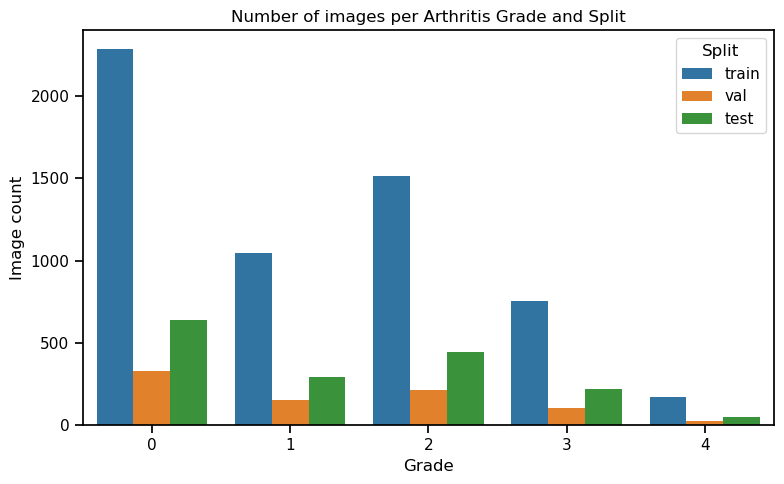

In [11]:
plt.figure(figsize=(8, 5))
sns.barplot(data=eda_counts_df, x="grade", y="count", hue="split")
plt.title("Number of images per Arthritis Grade and Split")
plt.xlabel("Grade")
plt.ylabel("Image count")
plt.legend(title="Split")
plt.tight_layout()
plt.show()

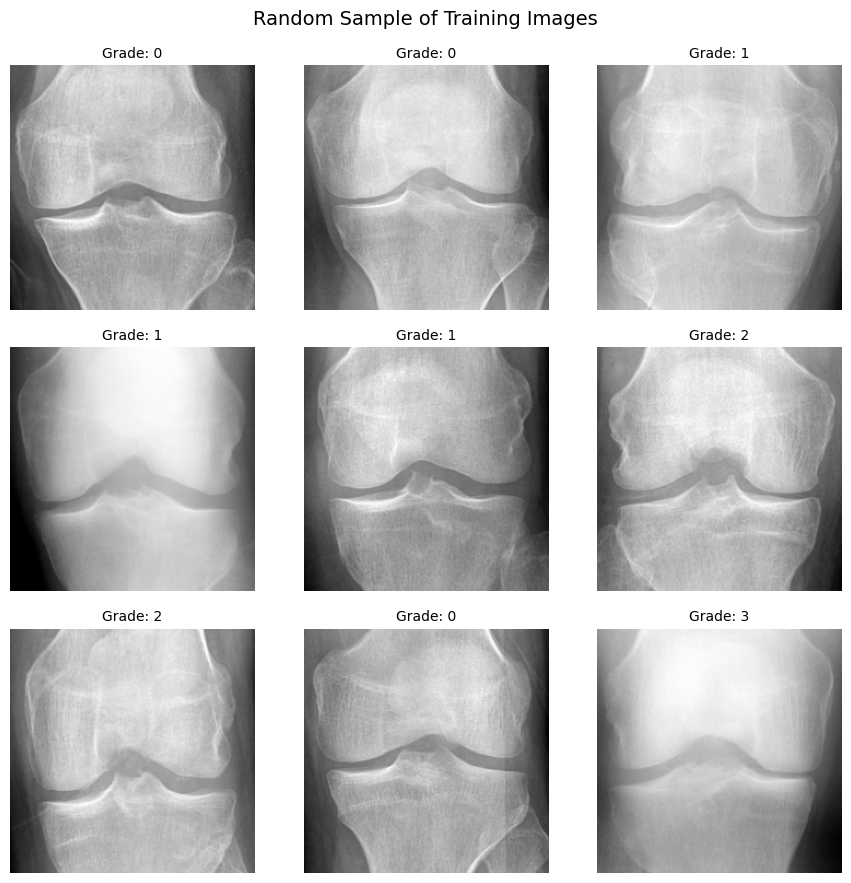

In [ ]:
def get_all_image_paths(root_dir):
    """Return list of (filepath, label_int) tuples."""
    all_paths = []
    for label in sorted(os.listdir(root_dir)):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            imgs = [
                (os.path.join(label_dir, f), int(label))
                for f in os.listdir(label_dir)
                if f.lower().endswith((".png", ".jpg", ".jpeg"))
            ]
            all_paths.extend(imgs)
    return all_paths


#collect paths from train_dir (can change to val_dir or test_dir)
all_train_paths = get_all_image_paths(train_dir)

#randomly sample 9 images
sampled = random.sample(all_train_paths, 9)

#plot 3×3 grid
plt.figure(figsize=(9, 9))

for i, (img_path, label) in enumerate(sampled):
    img = Image.open(img_path).convert("L")
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Grade: {label}", fontsize=10)
    plt.axis("off")

plt.suptitle("Random Sample of Training Images", fontsize=14)
plt.tight_layout()
plt.show()


for some more EDA, i will collect and view the image metadata

In [8]:
def collect_image_metadata(root_dir):
    """
    Walk through train/val/test folders and collect:
        - filepath
        - label (KL grade)
        - height
        - width
        - file size (KB)
    """
    records = []

    for split in ["train", "val", "test"]:
        split_path = os.path.join(root_dir, split)
        for label in sorted(os.listdir(split_path)):
            label_dir = os.path.join(split_path, label)
            if not os.path.isdir(label_dir):
                continue

            for fname in os.listdir(label_dir):
                if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    fpath = os.path.join(label_dir, fname)

                    try:
                        img = Image.open(fpath)
                        width, height = img.size
                        img.close()
                    except Exception as e:
                        print(f"Could not load {fpath}: {e}")
                        continue

                    size_kb = os.path.getsize(fpath) / 1024.0

                    records.append({
                        "filepath": fpath,
                        "split": split,
                        "label": int(label),
                        "width": width,
                        "height": height,
                        "file_size_kb": size_kb,
                    })

    return pd.DataFrame(records)


# Collect metadata
metadata_df = collect_image_metadata(BASE_DIR)
metadata_df.head()

,filepath,split,label,width,height,file_size_kb
0,d:\arthritis_detection_deep_learning\deep-lear...,train,0,224,224,18.356445
1,d:\arthritis_detection_deep_learning\deep-lear...,train,0,224,224,23.594727
2,d:\arthritis_detection_deep_learning\deep-lear...,train,0,224,224,15.313477
3,d:\arthritis_detection_deep_learning\deep-lear...,train,0,224,224,17.416992
4,d:\arthritis_detection_deep_learning\deep-lear...,train,0,224,224,20.323242


quickly confirm all files are the same width & height

In [9]:
expected_w, expected_h = 224, 224

mismatch_files = []

for idx, row in metadata_df.iterrows():
    w, h = row["width"], row["height"]
    if w != expected_w or h != expected_h:
        mismatch_files.append((row["filepath"], w, h))

if len(mismatch_files) == 0:
    print("All images are exactly 224x224.")
else:
    print(f"found {len(mismatch_files)} images that are not 224x224:")

All images are exactly 224x224.


## EDA Discussion:
all images are 224x224 .png files that appear in grayscale, as shown by the sample 3x3 grid, above. This data appears to be ideal for CNN and RNN applications. 

Now I will go ahead and create tf datasets so that I can efficiently and effectively build and train my models!

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=RANDOM_STATE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="int",
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False
)

class_names = train_ds.class_names
print("Class names:", class_names)

Found 5778 files belonging to 5 classes.
Found 826 files belonging to 5 classes.
Found 1656 files belonging to 5 classes.
Class names: ['0', '1', '2', '3', '4']


Here I will prepare the data for training, including rescaling. 

In [13]:
def prepare_for_training(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000, seed=RANDOM_STATE)
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_prep = prepare_for_training(train_ds, shuffle=True)
val_ds_prep   = prepare_for_training(val_ds)
test_ds_prep  = prepare_for_training(test_ds)

rescale = layers.Rescaling(1.0 / 255)

## CNN Model: Convolutional Neural Network
here i build my CNN model

In [14]:
def build_cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)

    x = rescale(inputs)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

cnn_model = build_cnn_model()
cnn_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,501 (49.36 MB)

 Trainable params: 12,938,501 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

## Train CNN
Now i will train the CNN model:

In [15]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_cnn = cnn_model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 84s 451ms/step - accuracy: 0.3875 - loss: 1.4183 - val_accuracy: 0.4044 - val_loss: 1.4286
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 83s 457ms/step - accuracy: 0.3986 - loss: 1.4026 - val_accuracy: 0.4165 - val_loss: 1.4145
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 83s 460ms/step - accuracy: 0.4036 - loss: 1.3913 - val_accuracy: 0.4044 - val_loss: 1.3900
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 83s 460ms/step - accuracy: 0.4126 - loss: 1.3748 - val_accuracy: 0.3983 - val_loss: 1.3790
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 86s 473ms/step - accuracy: 0.4318 - loss: 1.3488 - val_accuracy: 0.4080 - val_loss: 1.3544
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 84s 464ms/step - accuracy: 0.4387 - loss: 1.3165 - val_accuracy: 0.4274 - val_loss: 1.3282
Epoch 7/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 84s 462ms/step - accuracy: 0.4560 - loss: 1.2728 - val_accuracy: 0.4540 - val_loss: 1.2897
Epoch 8/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 84s 462ms/step - accuracy: 0.4737 - loss: 1

Here I'll plot my CNN training history:

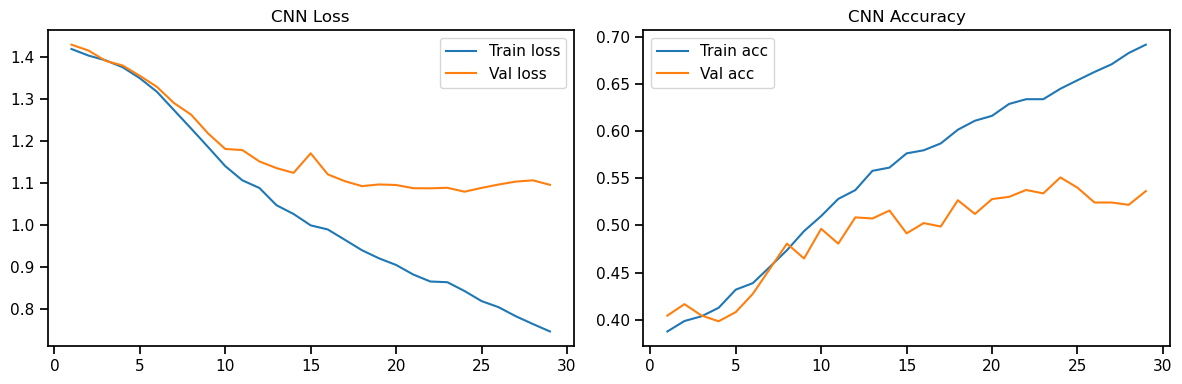

In [16]:
def plot_training_history(history, title_prefix="CNN"):
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist["loss"], label="Train loss")
    plt.plot(epochs, hist["val_loss"], label="Val loss")
    plt.title(f"{title_prefix} Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist["accuracy"], label="Train acc")
    plt.plot(epochs, hist["val_accuracy"], label="Val acc")
    plt.title(f"{title_prefix} Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_cnn, "CNN")

you can see that my validation loss slows significantly after the 15th epoch, and my validation accuracy levels off around the same time. Training loss and training accuracy continue to improve with each epoch. I could possibly get away with only 15 epochs if training this model was significant stress on my machine. As it stands, however, I am keeping the 30 epochs as a ~40 minute training period is acceptable to me with this particular machine. 